In [4]:
import json

with open('../data/posts_data_20241217_192033.json', 'r') as file:
    data = json.load(file)

print(data[0])

{'title': 'Nerve block didn’t work', 'author': 'xKittyxKultx', 'created_timestamp': '2024-12-05T17:03:20.508000+0000', 'score': '2', 'upvote_ratio': 0, 'content': 'I have done the steroid injections in my sacroiliac joint twice and they helped maybe 75% the first time and 50% the second time, but made my sugar go too high so I wanted to explore other optionsMy new dr is convinced I don’t have fibro but isn’t sure what it is yet. He said I should get a nerve block and it will have me feeling like I have a new back for a few hours, then they can burn the nerves. But I just got it done at 9 and I have no relief and the pain of the shot was way worse than the steroid injections. I am still having a lot of pain in the injection site and although I was trying to go today without meds to see if this helped, I caved and had to take a pain pill in order to have basic movement backI have been unable to get out of my bed or bend over since I got home.Has anyone else experienced this? What does it

In [5]:
posts_texts = []
for post in data:
    post_text = post["title"] + " " + post["content"]
    for comment in post["comments"]:
        post_text += " " + comment["text"]
        for reply in comment["replies"]:
            post_text += " " + reply["text"]
    posts_texts.append(post_text)

print(posts_texts[0])

Nerve block didn’t work I have done the steroid injections in my sacroiliac joint twice and they helped maybe 75% the first time and 50% the second time, but made my sugar go too high so I wanted to explore other optionsMy new dr is convinced I don’t have fibro but isn’t sure what it is yet. He said I should get a nerve block and it will have me feeling like I have a new back for a few hours, then they can burn the nerves. But I just got it done at 9 and I have no relief and the pain of the shot was way worse than the steroid injections. I am still having a lot of pain in the injection site and although I was trying to go today without meds to see if this helped, I caved and had to take a pain pill in order to have basic movement backI have been unable to get out of my bed or bend over since I got home.Has anyone else experienced this? What does it mean other than that it’s obviously not my nerves? I’m super disappointed bc I was looking forward to this “new back” I was promised 😭 I al

In [6]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download("stopwords")
nltk.download("wordnet")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/julienh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/julienh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"u/\S+", "", text)  # Remove usernames
    text = re.sub(r"r/\S+", "", text)  # Remove subreddit mentions
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove punctuation and special characters
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)

cleaned_posts_texts = [preprocess_text(post_text) for post_text in posts_texts]

In [8]:
# save cleaned posts texts to file
with open('cleaned_posts_texts.txt', 'w') as file:
    for text in cleaned_posts_texts:
        file.write(text + "\n")


In [9]:
# LDA with Gensim
from gensim import corpora
from gensim.models import LdaModel

# Create a dictionary representation of the documents.
dictionary = corpora.Dictionary([text.split() for text in cleaned_posts_texts])
# Filter out extremes (similar to the min_df and max_df parameters in sklearn)
dictionary.filter_extremes(no_below=5, no_above=0.5)  #  
# Create a bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(text.split()) for text in cleaned_posts_texts]
# Train the LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=42, passes=10)

# Print the topics
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic: {idx} \nWords: {topic}\n")


Topic: 0 
Words: 0.006*"bad" + 0.006*"got" + 0.005*"youre" + 0.005*"something" + 0.004*"better" + 0.004*"sorry" + 0.004*"thats" + 0.004*"sleep" + 0.004*"people" + 0.004*"lot"

Topic: 1 
Words: 0.010*"people" + 0.007*"surgery" + 0.005*"see" + 0.005*"nerve" + 0.004*"patient" + 0.004*"issue" + 0.004*"care" + 0.004*"life" + 0.004*"u" + 0.004*"say"

Topic: 2 
Words: 0.014*"med" + 0.010*"drug" + 0.008*"medication" + 0.006*"patient" + 0.006*"people" + 0.006*"pharmacy" + 0.004*"management" + 0.004*"doc" + 0.004*"dose" + 0.004*"opioid"

Topic: 3 
Words: 0.011*"people" + 0.011*"life" + 0.006*"way" + 0.006*"u" + 0.005*"still" + 0.005*"love" + 0.004*"say" + 0.004*"thats" + 0.004*"youre" + 0.004*"bad"

Topic: 4 
Words: 0.005*"mg" + 0.005*"lot" + 0.005*"muscle" + 0.005*"medication" + 0.004*"effect" + 0.004*"use" + 0.004*"long" + 0.004*"dose" + 0.004*"got" + 0.004*"cbd"



In [10]:
import pyLDAvis.gensim_models
import pyLDAvis

# Assuming you have your trained LDA model (lda_model) and corpus from the previous examples:

# Prepare the visualization data
vis_data = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

# Display the visualization in your browser
#pyLDAvis.display(vis_data)

# You can also save it as an HTML file:
pyLDAvis.save_html(vis_data, 'lda_visualization.html')

## Bert Topic Modelling and Analysis

In [11]:

# BERTopic
from bertopic import BERTopic

topic_model = BERTopic(language="english", calculate_probabilities=False, verbose=True)
topics, _ = topic_model.fit_transform(cleaned_posts_texts)

# Get the topics
topic_model.get_topic_info()
# Print the top 10 most frequent topics
print(topic_model.get_topic_info().head(10))

# Get the top n terms per topic
n_terms = 5
for i in range(len(set(topics)) - 1):  # Exclude outlier topic -1
    print(f"Topic {i}: {topic_model.get_topic(i)[:n_terms]}\n")

2024-12-18 00:48:22,228 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

2024-12-18 00:48:26,610 - BERTopic - Embedding - Completed ✓
2024-12-18 00:48:26,611 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2024-12-18 00:48:30,176 - BERTopic - Dimensionality - Completed ✓
2024-12-18 00:48:30,177 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-12-18 00:48:30,192 - BERTopic - Cluster - Completed ✓
2024-12-18 00:48:30,193 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-12-18 00:48:30,313 - BERTopic - Representation - Completed ✓


   Topic  Count                           Name  \
0     -1    230            -1_pain_im_get_like   
1      0    155            0_im_pain_like_feel   
2      1    129            1_pain_im_get_nerve   
3      2     35     2_people_pain_chronic_dont   
4      3     33  3_pharmacy_day_pharmacist_get   
5      4     33         4_pain_doctor_drug_med   
6      5     30           5_pain_take_med_like   
7      6     10           6_pain_scale_im_like   

                                      Representation  \
0  [pain, im, get, like, doctor, dont, help, know...   
1  [im, pain, like, feel, get, dont, day, time, l...   
2  [pain, im, get, nerve, back, like, disc, ive, ...   
3  [people, pain, chronic, dont, think, insurance...   
4  [pharmacy, day, pharmacist, get, drug, med, pa...   
5  [pain, doctor, drug, med, get, medication, wou...   
6  [pain, take, med, like, tramadol, get, mg, im,...   
7  [pain, scale, im, like, doctor, dont, get, day...   

                                 Representat

/Users/julienh/.pyenv/versions/3.10.0/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/julienh/.pyenv/versions/3.10.0/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/julienh/.pyenv/versions/3.10.0/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


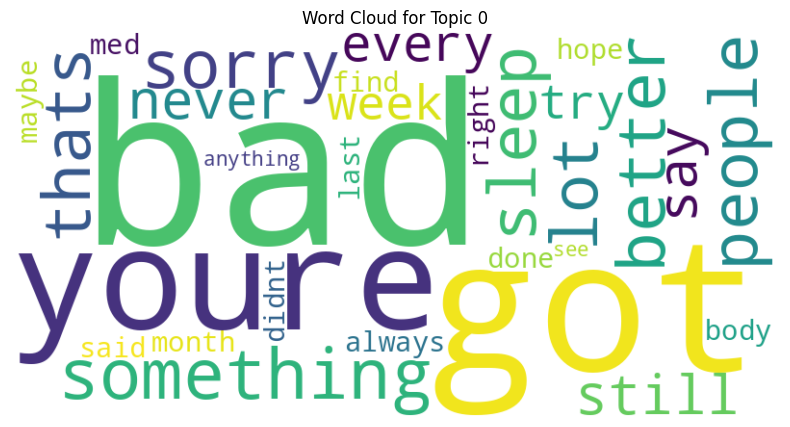

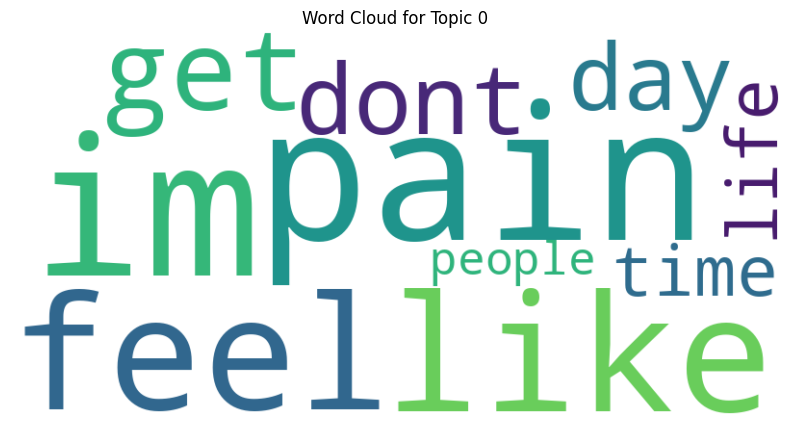

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud_for_topic(topic_id, model, num_words=30):
    """
    Generates a word cloud for a specific topic.

    Args:
        topic_id: The ID of the topic.
        model: The trained LDA or BERTopic model.
        num_words: The number of top words to include in the word cloud.
    """

    if isinstance(model, LdaModel):
        # For Gensim LDA model
        words = dict(model.show_topic(topic_id, num_words))
    elif isinstance(model, BERTopic):
        # For BERTopic model
        words = {word: prob for word, prob in model.get_topic(topic_id)}
    else:
        raise ValueError("Unsupported model type")

    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(words)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Topic {topic_id}")
    plt.show()

# Example usage with LDA:
create_wordcloud_for_topic(0, lda_model)  # Create a word cloud for topic 0

# Example usage with BERTopic:
create_wordcloud_for_topic(0, topic_model)  # Create a word cloud for topic 0

In [14]:
from umap import UMAP
import matplotlib.pyplot as plt
from bertopic import BERTopic
import plotly.express as px
import pandas as pd

# Assuming you have already trained your BERTopic model (topic_model) 
# and have your cleaned_posts_texts

# Get embeddings from the topic model
embeddings = topic_model.embedding_model.embed(cleaned_posts_texts)

# 1. Reduce dimensionality with UMAP (recommended)
umap_model = UMAP(n_neighbors=15, n_components=2, metric='cosine', random_state=42)
reduced_embeddings = umap_model.fit_transform(embeddings)

# 2. Visualize reduced embeddings
# For interactive plots use visualize_documents
# topic_model.visualize_documents(docs=cleaned_posts_texts, embeddings=embeddings, reduced_embeddings=reduced_embeddings)

# For static plots you can use matplotlib:
topics = topic_model.topics_

# Prepare the data for plotting
df = pd.DataFrame({"x": reduced_embeddings[:, 0], "y": reduced_embeddings[:, 1], "topic": topics})

# Create the plot
fig = px.scatter(df, x="x", y="y", color="topic", hover_data=["topic"], title="t-SNE Visualization of Document Embeddings")

# Customize the layout
fig.update_layout(
    xaxis_title="Dimension 1",
    yaxis_title="Dimension 2",
    legend_title="Topic",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="RebeccaPurple"
    )
)

fig.show()